
# An introduction to Altar2 framework - from a Linear Model example


In this tutorial, we use a linear model to demonstrate the AlTar framework. 

### 1. Introduction

AlTar solves inverse problem by Bayesian inference with [CATMIP](https://thesis.library.caltech.edu/5918/) algorithm. 

A forward model can be defined as $d=G(\theta)$, where $\theta$ is a set of parameters, $d$ is a set of predicted observations, and $G$ is the forward function(s) to calculate $d$ from a given $\theta$. For example, in a linear model, ${\vec d} = {\bf G} {\vec \theta}$, the Green's function ${\bf G}$ is a two-dimension matrix of the size (observations, parameters). In an inverse problem, one knows a set of observations $d$ and wants to calculate the parameters $\theta$ that produced them, or $\theta = G^{-1} (d)$. In most cases, $G$ is not directly inversible. 

We resort to the Bayesian inference method, which follows the Bayes' theorem:
$P(\theta|d) =  P(d|\theta) P(\theta)/P(d)$, i.e., the (posterior) probability of observing $\theta$ for a given $d$ is proportional to the (data likelihood) probability of observing $d$ for a given $\theta$ and the (prior) probablity of $\theta$ before taking the observation into account. $P(d|\theta)$ can be easily computed by the available forward model. One therefore samples the posterior distribution $P(\theta|d)$ over the $\theta$ parameter space, which provides a statistical solution for $\theta$ from its probability to produce the observed data $d$. 
(we take $P(d)=1$ in the following as it is the same for all $\theta$ being sampled in the process.)    

Such a statistical approach can also incorporate various uncertainies in reality, such as data collection errors, forward model uncertainties, which are not possible to include in the direct inverse method. 

CATMIP is a Markov-Chain Monte-Carlo (MCMC) method to sample the posterior distribution $P(\theta|d)$. It introduces an annealing process with transient distributions $P_m(\theta|d) =  [P(d|\theta)]^{\beta_m} P(\theta)$ and $\beta_m$ increasing from 0 to 1, i.e., to gradully equilibrate the samples $\theta$ being initialized from the prior to the desired posterior distribution.  

AlTar provides a framework for the above computation. It is based on the component-based programming by the pyre framework. The main components in an AlTar application are as follows, 
- Controller(default=annealer), which performs the MCMC simulation as prescribed by CATMIP. It also contains several components
    - Worker, which can be configured to run with single thread(default), multiple threads, CPU or GPU, and also keeps record of the simulation data such as $\theta$, prior/likelihood/posterior probabilities (in a CoolingStep object).
    - Sampler, which provides the sample updating process. The default sampler uses a Gaussian proposal and the Metropolis–Hastings algorithm for deciding acceptance/rejection of proposed samples. 
    - Scheduler, which controls the annealing schedule (how $\beta$ evolves from 0 to 1). The default scheduler is based on the Coefficient of Variance (COV), adjusted to maintain 50% the effective sample size. 
- Model, which controls the data likelihood computation from a prescribed forward model and a set of observed data. Several geophysical models are included in the package. Users can also develop their own models to take advantage of the Bayesian framework. 
- Job, for users to configure the size of the simulations, such as the number of chains, the number of threads, whether to use GPU. 
- Rng, the random number generator to be used in other components.  


### 2.  Create an AlTar application for Linear Model

The forward model of the linear model is ${\vec d} = {\bf G} {\vec m}$. We create a dedicated AlTar application for it as follows (users can also use the default altar application while specifying `model=altar.models.linear` in the configuration file),

In [1]:
import altar
import altar.models.linear

# make a specialized app that uses the linear model by default
class LinearApp(altar.shells.altar, family='altar.applications.linear'):
    """
    A specialized AlTar application that exercises the Linear model
    """
    # user configurable component
    model = altar.models.model(default='linear')


Users can use a pyre-config file to set various attributes/components in an AlTar application.  If the settings are not present, default values will be used. For example, we use [linear.pfg](linear.pfg) below for the linear model.

```
;
; michael a.g. aïvázis
; orthologue
; (c) 1998-2019 all rights reserved
;

; the application
; the name should be the same as the AlTar application instance (name='linear')
linear:
    ; the model configuration
    model:
        ; the name of the test case, also as the directory for input files
        case = patch-9
        ; the number of free parameters
        parameters = 18
        ; the number of observations
        observations = 108

        ; data observations
        data = data.txt
        
        ; data covariance/uncertainties
        cd = cd.txt
        
        ; Green's function 
        green = green.txt
        
        ; prior distribution for parameters
        ; use a prep distribution to initialize samples, if different
        prep:
            ; default distribution is gaussian
            parameters = {linear.model.parameters}
            center = 0.1
            sigma = 0.6

        ; prior distribution to compute prior
        prior:
            parameters = {linear.model.parameters}
            center = 0.0
            sigma = 0.5

    ; run configuration
    job.tasks = 1 ; number of tasks per host
    job.gpus = 0  ; number of gpus per task
    job.chains = 2**10 ; number of chains per task


; end of file
```

### 3. Create an instance and have a test run

In [2]:
# create an instance
myapp = LinearApp(name='linear')
# call initialize method to prepare its compone
myapp.initialize()
# to sample the posterior with CATMIP alogorithm
myapp.model.posterior(application=myapp)

altar: iteration: 0, beta: 0, scaling: 0.3
altar: stats(accepted/invalid/rejected): (0, 0, 0)
altar: step
  β: 0
  θ: (1024 samples) x (18 parameters)
  parameters (mean, sd):
   (0.018337881631437083, 0.5052453298270653)
   (0.014805859520560022, 0.4766894664140216)
   (-0.01462564513078194, 0.5081654158571511)
   (-0.002355673369142845, 0.5081162163836722)
   (-0.04118865774270952, 0.5073394241501916)
   (0.0017552032804668066, 0.5083596919672608)
   (-0.0020480581810896586, 0.49203214603015305)
   (0.006802537886870903, 0.5050897094148948)
   (0.019792637990626735, 0.5078926959999586)
   (-0.014077530688462712, 0.5285959116127767)
   (-0.01637361479187935, 0.5061220237476346)
   (0.009529041379845204, 0.4866321830486042)
   (0.0005823928357463203, 0.5064351771426218)
   (0.018808766714457793, 0.4980890641425079)
   (-0.006404183895994609, 0.5022449427854057)
   (-0.0036295692679261067, 0.5065645469133183)
   (0.013157615041441287, 0.5009381741599271)
   (0.0076002730544208795, 0.485

resampling: unique samples 528 out of 1024
altar: iteration: 8, beta: 0.005504861307286939, scaling: 0.36840277777777775
altar: stats(accepted/invalid/rejected): (5928, 0, 14552)
altar: step
  β: 0.005504861307286939
  θ: (1024 samples) x (18 parameters)
  parameters (mean, sd):
   (0.09405846095484405, 0.24609470724835844)
   (0.019053710022293256, 0.4472915981662028)
   (0.15243204242025846, 0.385493007638077)
   (0.16179025072654382, 0.23123133586488676)
   (0.13896167766343967, 0.44128980886950325)
   (0.19181921339762936, 0.2835697226403683)
   (0.22627562485692884, 0.2503086779318177)
   (0.1310839113853568, 0.4411375662969701)
   (0.05846397927712409, 0.37360189505526736)
   (1.0366027875509574, 0.2775254260218594)
   (0.8472597019711501, 0.3605345909509739)
   (0.5048150075561069, 0.42687814315561384)
   (0.5066343290769844, 0.47672813097723576)
   (0.7902788421768404, 0.41926586633211366)
   (0.46100384831310315, 0.44441240118224423)
   (1.0392557245225889, 0.26732994560652146

resampling: unique samples 514 out of 1024
altar: iteration: 16, beta: 0.11036651647711809, scaling: 0.40338541666666666
altar: stats(accepted/invalid/rejected): (6734, 0, 13746)
altar: step
  β: 0.11036651647711809
  θ: (1024 samples) x (18 parameters)
  parameters (mean, sd):
   (0.14894926437343936, 0.07788665252689668)
   (0.11477022743281758, 0.296821703215721)
   (0.21010451077374895, 0.17045483274498816)
   (0.1727997400855307, 0.0650616962555598)
   (0.1525789833438947, 0.3053539417922836)
   (0.1764787912690823, 0.11921456956349723)
   (0.19989735027961386, 0.0786030608469442)
   (0.1865869474152982, 0.29551780740667316)
   (0.14380581815828342, 0.18284525490182058)
   (1.0213451069014086, 0.12266449590344425)
   (0.9822318218664775, 0.18398241098569063)
   (0.9430378835119134, 0.251348147663664)
   (0.6842607074388799, 0.435387786623932)
   (1.0444204329849118, 0.25020917072318877)
   (0.9398400009072985, 0.3404641416975912)
   (1.0343929510471117, 0.12058682682300392)
   (0.

altar: step
  β: 1.0
  θ: (1024 samples) x (18 parameters)
  parameters (mean, sd):
   (0.1656482811525837, 0.0336925705251227)
   (0.15286536378727797, 0.13798873008285867)
   (0.1897899353182844, 0.07609184297577347)
   (0.17433196069187012, 0.023617954560353774)
   (0.1661300178223966, 0.14621649063422865)
   (0.1756237736758064, 0.0503495196557259)
   (0.18257210168135202, 0.03408649776768381)
   (0.1709503327365636, 0.14294560508139073)
   (0.16930620161521273, 0.07655422134985308)
   (0.9949989468314373, 0.05903949913806912)
   (0.989503438902692, 0.08573012494242761)
   (0.9792930441344794, 0.1322652334846431)
   (0.8690357684828713, 0.3091682864910447)
   (1.0146286334405816, 0.1423374818223276)
   (0.9878614192548045, 0.19028752780878203)
   (0.9977545889436173, 0.05684572580884658)
   (0.9822561612798978, 0.08225958834531748)
   (0.9753218910113398, 0.12473799506775192)


0

Some preocess information is shown to help users monitoring the annealing procedure, e.g.,   

### 4. Show the statistics of the final results
The states of MCMC simulations are stored in a 'step' object. We can extrat theta, prior/data (likelihood)/posterior as well as other simulation information for 'step' and perform further analysis. 

In [3]:
# to obtain the final step data
step=myapp.controller.worker.step
print('beta =', step.beta)
print('samples =', step.samples)
print('parameters =', step.parameters)
# to obtain theta matrix dim(samples, parameters)
theta = step.theta
mean_model, sd = theta.mean_sd(axis=0) # axis=0 for averaging over samples

beta = 1.0
samples = 1024
parameters = 18


In [4]:
model = myapp.model
model.green
model.G.shape

(108, 18)

Show the posterior distribution as a histograms

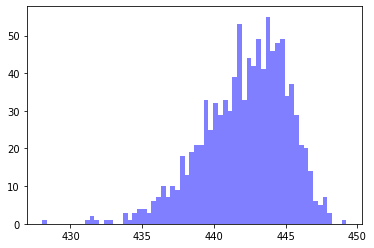

In [5]:
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
posterior = step.posterior
num_bins = 2**6
n, bins, patches = plt.hist(posterior, num_bins, facecolor='blue', alpha=0.5)
plt.show()

### 5. Output
The default archiver of AlTar saves step information in `results/step_nnn.h5` (HDF5) files for step=nnn. You may use `h5py` package to read progress data. For example, 

In [6]:
import h5py
import numpy 
# open the final step h5 file in read mode
h5file = h5py.File('results/step_final.h5', 'r') 
# show the root datasets 
print("list of datasets", list(h5file.keys()))
# show the datasets in Bayesian
print("list of datasets in Bayesian", list(h5file.get('Bayesian').keys()))
# get the posterior, vector (samples)
posterior = numpy.asarray(h5file.get('Bayesian/posterior'))
print("the dimension of posterior is the number of samples", posterior.size)
# show the datasets in ParameterSets
print("the list of parameter sets in ParameterSets", list(h5file.get('ParameterSets').keys()))
# get theta, a matrix(samples, parameters)
theta = numpy.asarray(h5file.get('ParameterSets/theta'))
print("the dimension of theta is (samples, parameter): ", theta.shape)
# close h5file when all done
h5file.close()

list of datasets ['Annealer', 'Bayesian', 'ParameterSets']
list of datasets in Bayesian ['likelihood', 'posterior', 'prior']
the dimension of posterior is the number of samples 1024
the list of parameter sets in ParameterSets ['theta']
the dimension of theta is (samples, parameter):  (1024, 18)


### 6. Play with other configurations
If you would like to run linear model with other configurations, edit the 'linear.pfg' file and use Kernel->"Restart & Run All" to re-run the program.